## Loading LAcourse Data

In [7]:
import numpy as np

filename_lacourse = '/project/portiloop-training/portiloop_software/dataset/20230515_130328_detectionVector_01-01-0001.csv'
# Load file
spindle_labels = np.loadtxt(filename_lacourse, delimiter=',')

In [25]:
len(spindle_labels) 

7638500

## Loading Signal data and Sleep stage

In [9]:
from portiloop_software.portiloop_python.ANN.data.mass_data import read_pretraining_dataset, read_sleep_staging_labels


subject_id = '01-01-0001'

ss_labels = read_sleep_staging_labels('/project/portiloop-training/portiloop_software/dataset/')
data = read_pretraining_dataset('/project/portiloop-training/portiloop_software/dataset/MASS', patients_to_keep=[subject_id])

/project/portiloop-training/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from portiloop_software.portiloop_python.ANN.data.mass_data import SingleSubjectDataset, read_spindle_trains_labels
old_dataset = "/project/portiloop-training/portiloop_software/dataset"
labels = read_spindle_trains_labels(old_dataset)
dataset = SingleSubjectDataset(subject_id, data=data, labels=labels, config=config, ss_labels=ss_labels)  

In [20]:
len(indexes)

12310

In [23]:
from portiloop_software.portiloop_python.ANN.utils import SpindlePlotter

plotter = SpindlePlotter(data[subject_id]['signal'], spindle_labels)

RMS score: 0.6754504764230409


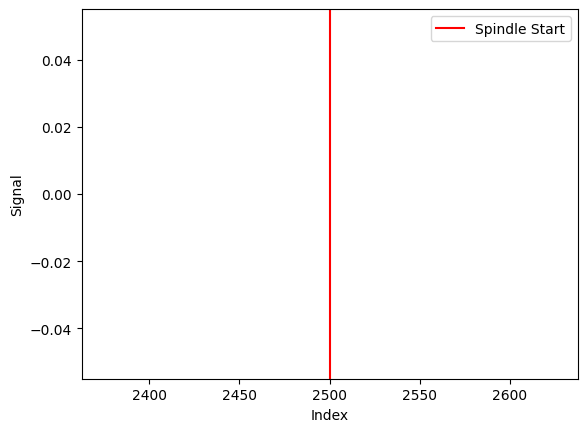

TypeError: 'NoneType' object is not subscriptable

In [26]:
plotter.plot(0)